In [23]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../scripts")
import numpy as np
import pandas as pd
import os
import scipy.stats 
import h5py
from tensorflow.python.keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import utils
import tensorflow as tf
from tqdm import tqdm
import evaluate
from modelzoo import GELU
import re
import global_importance
from matplotlib.ticker import MaxNLocator
import global_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
run_paths = ['paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5',
            'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5',
            'paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5',
            'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p/files/best_model.h5',
            'paper_runs/bpnet/bin_loss_40/run-20211013_133014-ku9mdrht/files/best_model.h5']
cell_lines = 'PC-3'
motif_pairs = ['..TGA.TCA..,..TGA.TCA..', '..TGA.TCA..,..GATAA..', '..TGA.TCA..,..ATAAA..']
command_lines = []
for background in ['dinuc']:
        for run_path in run_paths:
            for motif_pair in motif_pairs:
                command_lines.append('python ./add_GIA_no_pos_opt.py {} {} {} {}'.format(run_path, motif_pair, background, cell_lines))

In [73]:
with open('../add_gia_commands.txt', 'w') as f:
    for item in command_lines:
        f.write("%s\n" % item)

In [81]:
!head -n3 ../add_gia_commands.txt

python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..TGA.TCA.. dinuc PC-3
python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..GATAA.. dinuc PC-3
python ./add_GIA_no_pos_opt.py paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5 ..TGA.TCA..,..ATAAA.. dinuc PC-3


# Plot results

In [5]:
motif_dict = {'..GATAA..': 'GATA', 
             '..TGA.TCA..':'AP-1',
             '..ATAAA..': 'ATAAA'}

model_dict = {'run-20211019_161849-9ygdmjss':'mod_binary',
             'run-20210825_040148-nieq47kf': 'basset',
             'run-20211023_095131-w6okxt01': '32_new',
             'run-20210923_162932-56p3xy2p':'basenji',
              'run-20211013_133014-ku9mdrht': 'bpnet'
             }
# result_dirs = glob.glob('add_GIA_interaction/*')
background = 'dinuc'
cell_line = 'PC-3'
base_dir = 'add_GIA_interaction'
result_dirs = [base_dir+d for d in [
            '/run-20210825_040148-nieq47kf',
            '/run-20211019_161849-9ygdmjss',
             '/run-20210923_162932-56p3xy2p',
             '/run-20211013_133014-ku9mdrht',
             '/run-20211023_095131-w6okxt01']  ]     

In [6]:
cell_spec_res = []
for result_dir in result_dirs:

    model_name = model_dict[result_dir.split('/')[-1]]
    all_motif_pairs = set([''.join(d.split('_')[1:]) for d in os.listdir(result_dir) if '_and_' in d])
    for motifs in list(all_motif_pairs):
#     for motifs in ['..TGA.TCA..and..TGA.TCA..']:
        motif1, motif2 = motifs.split('and')
        motif_res_path = os.path.join(result_dir, '{}_{}'.format(cell_line, '_and_'.join([motif1, motif2])), '{}_N1000'.format(background))
        int_df = pd.read_csv(os.path.join(motif_res_path, '1024_best_distance_interaction.csv')).iloc[:,1:]

        polished_names = []
        for m in int_df['motif'].values:
            p = []
            list_of_single_motifs = m.split('&')
            split_m = [single_m.split(' at ') for single_m in list_of_single_motifs]
            for motif, coord in split_m:
                p.append('{} {}'.format([v for k,v in motif_dict.items() if re.match(k, motif.strip())][0], coord))
            polished_names.append('&\n'.join(p))
        int_df['added motif'] = polished_names
        m1_df = int_df.iloc[np.argwhere([True if '1024' in p and '&' not in p else False for p in polished_names]).flatten()]
        m2_df = int_df.iloc[np.argwhere([True if '1024' not in p and '&' not in p else False for p in polished_names]).flatten()]
        sum_diffs = m1_df['mean difference'].values + m2_df['mean difference'].values
        df = pd.DataFrame()
        df['mean difference'] = sum_diffs
        df['cell line'] = m1_df['cell line'].values
        df['motif'] = 'sum'
        df['added motif'] = 'sum'
        int_df = pd.concat([int_df, df])


        int_df['model'] = model_name
        int_df['group'] = motifs
        cell_spec_res.append(int_df[int_df['cell line'] == cell_line])
all_dfs = pd.concat(cell_spec_res)

In [7]:
all_motif_pairs

{'..TGA.TCA..and..ATAAA..',
 '..TGA.TCA..and..GATAA..',
 '..TGA.TCA..and..TGA.TCA..'}

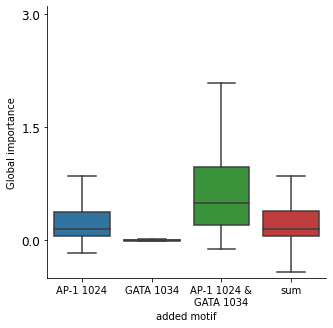

In [252]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..GATAA..')&(all_dfs['model']=='32_new')]
fig, ax = plt.subplots(figsize=[5, 5])
g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False, ax=ax)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('Global importance')
plt.ylim(-0.5, 3.1)
g.yaxis.set_major_locator(MaxNLocator(3))
plt.yticks(fontsize=12)
plt.savefig('7c-1.svg')

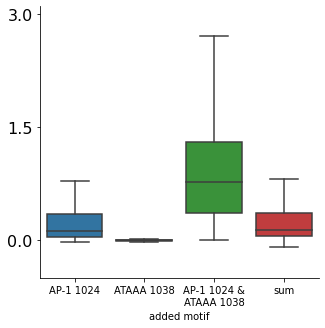

In [250]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..ATAAA..')&(all_dfs['model']=='32_new')]
fig, ax = plt.subplots(figsize=[5, 5])
g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False, ax=ax)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('')
plt.ylim(-0.5, 3.1)
g.yaxis.set_major_locator(MaxNLocator(3))
plt.yticks(fontsize=16)
plt.savefig('7c-2.svg')

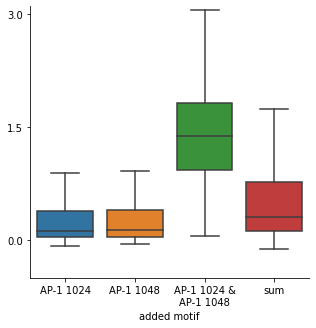

In [251]:
df = all_dfs[(all_dfs['group']=='..TGA.TCA..and..TGA.TCA..')&(all_dfs['model']=='32_new')]
fig, ax = plt.subplots(figsize=[5, 5])


g=sns.boxplot(data=df, x='added motif', y='mean difference', showfliers=False, ax=ax)
g.spines['top'].set_visible(False)
g.spines['right'].set_visible(False)
plt.ylabel('')
plt.ylim(-0.5, 3.1)
g.yaxis.set_major_locator(MaxNLocator(3))
# plt.yticks(fontsize=16)
plt.savefig('7c-3.svg')

/home/shush/.local/lib/python3.8/site-packages/seaborn/categorical.py:3806: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


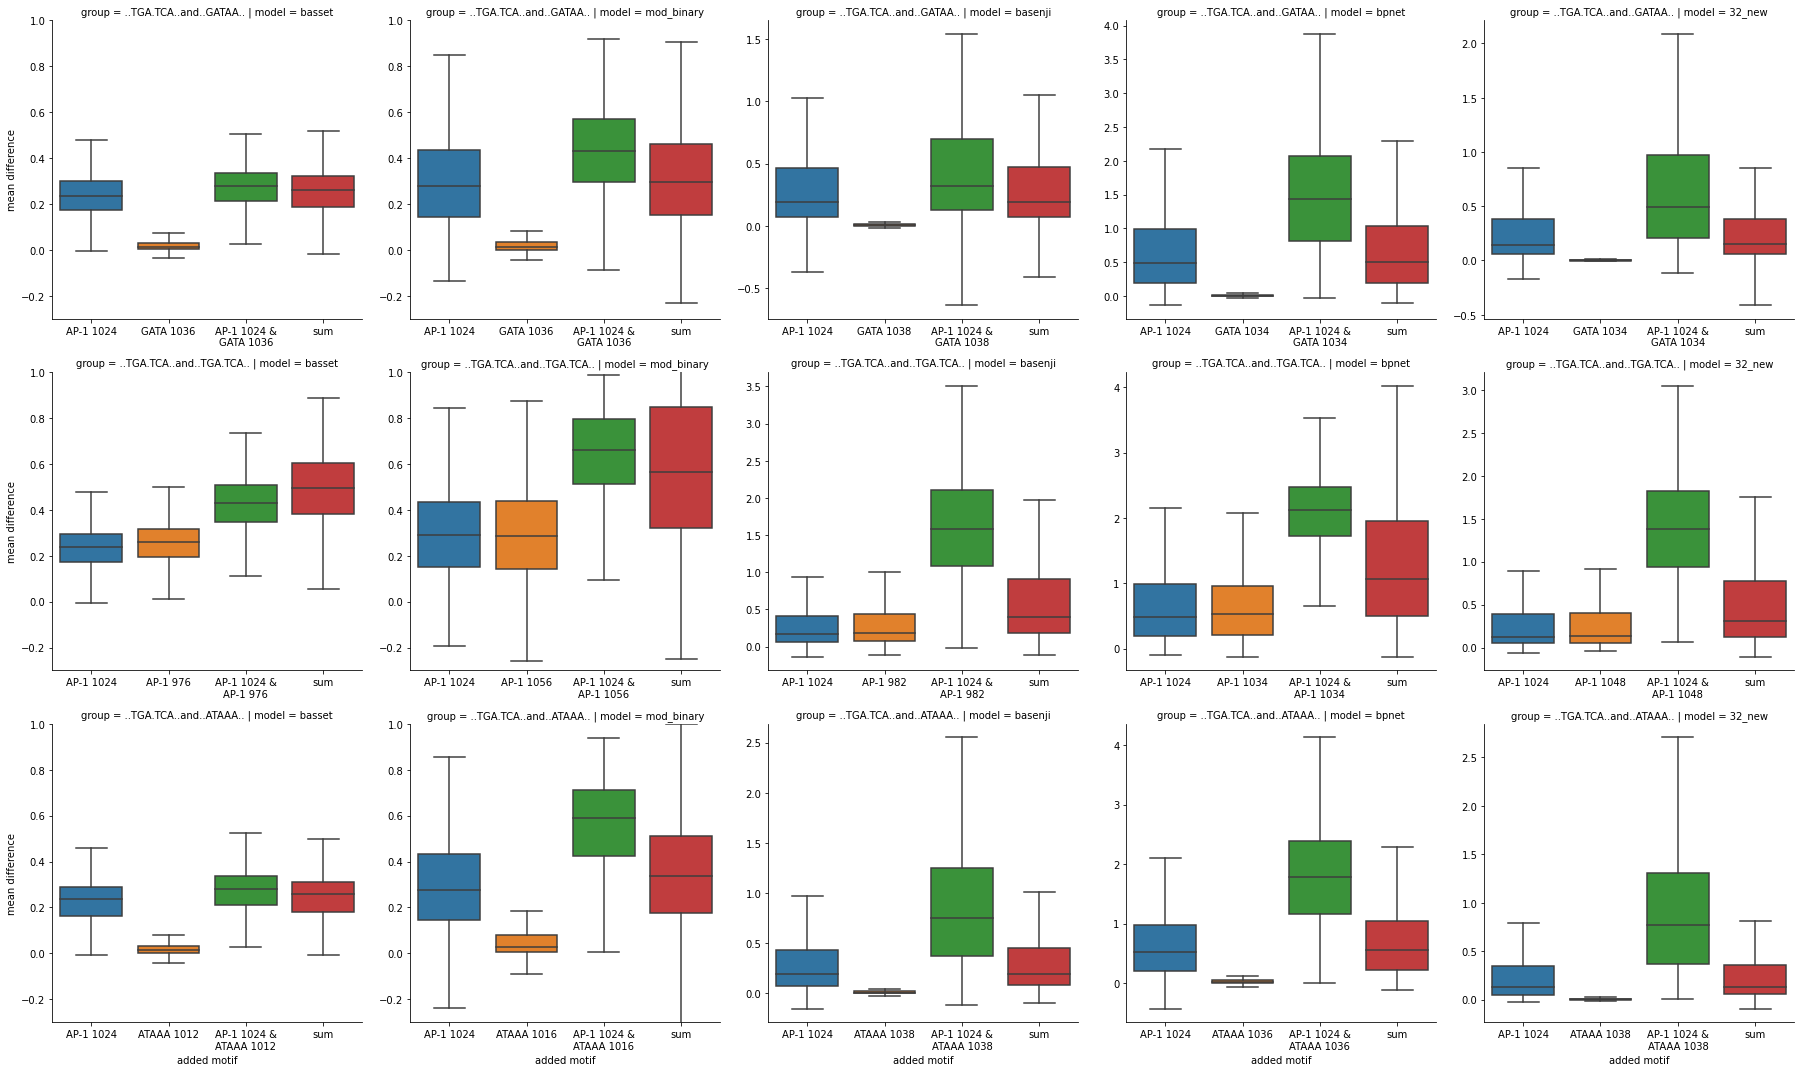

In [11]:

# df = list(iter(all_dfs.groupby('group')))[0][1]
g = sns.catplot(data=all_dfs, x='added motif',y='mean difference', row='group', sharex=False,
            kind='box', sharey=False, col='model',showfliers = False, palette='tab10')
axs = g.axes
for r in range(axs.shape[0]):
    for c in range(2):
        axs[r][c].set_ylim(-0.3,1)
        
# axs[0][:].set_ylim(-0.3,1)
# axs[1][:].set_ylim(-0.3,1)
# plt.xticks(rotation=90)

# Flanks

/tmp/ipykernel_1492890/7662302.py:34: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1492890/7662302.py:34: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


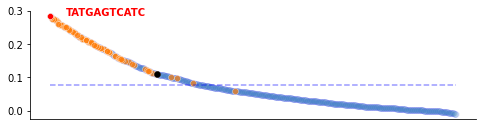

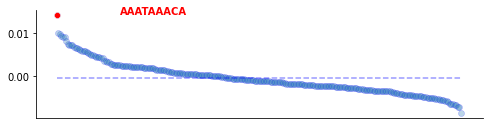

In [28]:
cell_line = 'PC-3'
run_name = 'run-20211023_095131-w6okxt01'

for i, motif_insert in enumerate([[('TGA', 1024), ('TCA', 1024+len('TGA')+1)], [('ATAAA', 1024)]]):
    if i ==0:
        alpha=0.07
    else:
        alpha=0.3
    motif_pattern = '.'.join([m[0] for m in motif_insert])
    plt.figure(figsize=[8,2])
    flanks = pd.read_csv('/home/shush/old_grounhog/paper_figures/add_GIA_interaction/{}/PC-3_..{}../dinuc_N1000/flanks.csv'.format(run_name, motif_pattern))
    sorted_flanks = flanks[flanks['cell line']==cell_line].sort_values('mean difference')[::-1]
    sns.scatterplot(data=sorted_flanks, 
                    x='motif', y='mean difference', edgecolor='blue', alpha=alpha)
    mean_of_all = sorted_flanks['mean difference'].mean()
    plt.hlines(mean_of_all,0, len(sorted_flanks['motif'].values), 'blue', linestyles='--', alpha=0.4)
    
    plt.text(40, sorted_flanks.iloc[0,1], sorted_flanks.iloc[0,0], 
         horizontalalignment='left', size='medium', color='red', weight='semibold')
    
    if i == 0:
        pc3 = flanks[flanks['cell line']=='PC-3'].reset_index()
        jaspar_motifs = []
        for r, row in pc3.iterrows():
            m = row['motif']
            if m[0] in 'GAT' and m[1] in 'GAC' and m[5] in 'CG' and m[9] in 'TC' and m[10] in 'CGT':
                jaspar_motifs.append(r)
        sns.scatterplot(data=pc3.iloc[jaspar_motifs], x='motif', y='mean difference', alpha=0.7)
        point_at_min = pc3.iloc[jaspar_motifs].sort_values('mean difference').iloc[4]
        p = np.argwhere(sorted_flanks['motif'].values==point_at_min['motif'])[0][0]
        point_df = sorted_flanks.iloc[p].to_frame().T
        sns.scatterplot(data=point_df, x='motif',
                        y='mean difference', color='k', edgecolor=None)
    plt.xticks([])
    a = sns.scatterplot(x=[0],y=[sorted_flanks.iloc[0,1]], color='r')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    plt.ylabel('')
    plt.xlabel('')
    plt.savefig('7a_{}.svg'.format(i))

# distance

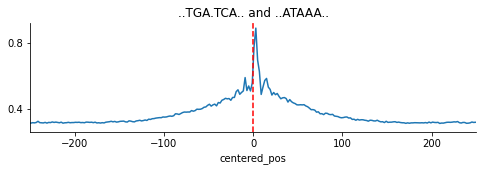

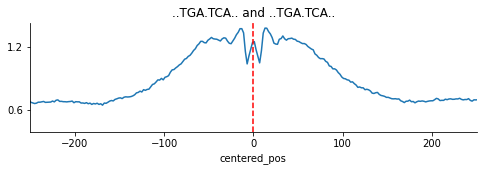

In [221]:

m1_s = 1024
m1 = '..TGA.TCA..'

for m2 in ['..ATAAA..', '..TGA.TCA..']:
    cell_line = 'PC-3'
    df = pd.read_csv('add_GIA_interaction/run-20211023_095131-w6okxt01/{}_{}_and_{}/dinuc_N1000/1024_distance.csv'.format(cell_line, m1, m2))
    df['insertion position'] = [int(d.split('_')[1]) for d in df['motif 2']]
    dist_df = df[df['cell line']==cell_line].reset_index()
    pos = dist_df['insertion position'].values
    dist_df = dist_df.iloc[np.argwhere((pos<m1_s-len(m2)+1)|(pos>m1_s+len(m1))).flatten()]
    new_pos_minus = dist_df[dist_df['insertion position']<=m1_s-len(m2)+1]['insertion position'].values - 1024 + len(m2)
    new_pos_plus = dist_df[dist_df['insertion position']>m1_s+len(m1)]['insertion position'].values - 1024 - len(m1)
    dist_df['centered_pos'] = np.concatenate([new_pos_minus, new_pos_plus])  
    plt.figure(figsize=[8,2])
    ax = sns.lineplot(data=dist_df, x='centered_pos', y='mean difference')
    plt.ylabel('')
    plt.xlim(-250, 250)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title('{} and {}'.format(m1, m2))
    plt.axvline(x=0, ymin=0, ymax=1, c='r', linestyle='--')
    ax.yaxis.set_major_locator(MaxNLocator(2))
    plt.savefig('GIA_b_{}.svg'.format(m2))


# occlude

In [53]:
run_paths = ['paper_runs/binary/basset/run-20210825_040148-nieq47kf/files/best_model.h5',
            'paper_runs/new_models/32_res/run-20211023_095131-w6okxt01/files/best_model.h5',
            'paper_runs/binary/mod_binary/run-20211019_161849-9ygdmjss/files/best_model.h5',
            'paper_runs/basenji/binloss_basenji/run-20210923_162932-56p3xy2p/files/best_model.h5',
            'paper_runs/bpnet/bin_loss_40/run-20211013_133014-ku9mdrht/files/best_model.h5']
cell_lines = 'all'
motif_pairs = ['TGA.TCA,GATAA', 'TGA.TCA,ATAAA']
command_lines = []
for background in ['dinuc']:
        for run_path in run_paths:
            for motif_pair in motif_pairs:
                command_lines.append('python ./occlude_motifs_GIA.py {} {} {} {}'.format(run_path, motif_pair, background, cell_lines))

In [54]:
with open('../remove_gia_commands.sh', 'w') as f:
    for item in command_lines:
        f.write("%s\n" % item)

In [24]:
motif_dict = {'..GATAA..': 'GATA', 
             '..TGA.TCA..':'AP-1',
             '..ATAAA..': 'ATAAA'}
base_dir = 'occlude_GIA_fin'
model_dict = {base_dir+'/run-20211019_161849-9ygdmjss':'mod_binary',
             base_dir+'/run-20210825_040148-nieq47kf': 'basset',
             base_dir+'/run-20211023_095131-w6okxt01': '32_new',
             base_dir+'/run-20210923_162932-56p3xy2p':'basenji',
              base_dir+'/run-20211013_133014-ku9mdrht': 'bpnet'
             }
# result_dirs = glob.glob('add_GIA_interaction/*')
background = 'dinuc'
cell_line = 'PC-3'
result_dirs = [base_dir+d for d in [
            '/run-20210825_040148-nieq47kf',
            '/run-20211019_161849-9ygdmjss',
             '/run-20210923_162932-56p3xy2p',
             '/run-20211013_133014-ku9mdrht',
             '/run-20211023_095131-w6okxt01']  ]          
            

In [30]:
cell_spec_res = []
for result_dir in result_dirs:
    model_name = model_dict[result_dir]
    all_motif_pairs = set([''.join(d.split('all_')[-1]) for d in os.listdir(result_dir) if 'all_' in d])
    for motifs in list(all_motif_pairs):
#     for motifs in ['..TGA.TCA..and..TGA.TCA..']:
        motif1, motif2 = motifs.split(',')
        motif_res_path = os.path.join(result_dir, 'all_'+motifs, '{}_N1000'.format(background))
        files = os.listdir(motif_res_path)
        assert len(files) == 1, 'incorrect number of files!'
        int_df = pd.read_csv(os.path.join(motif_res_path, files[0]))
        
        int_df['model'] = model_name
        int_df['group'] = motifs
        cell_spec_res.append(int_df[int_df['cell line'] == cell_line])
all_dfs = pd.concat(cell_spec_res)

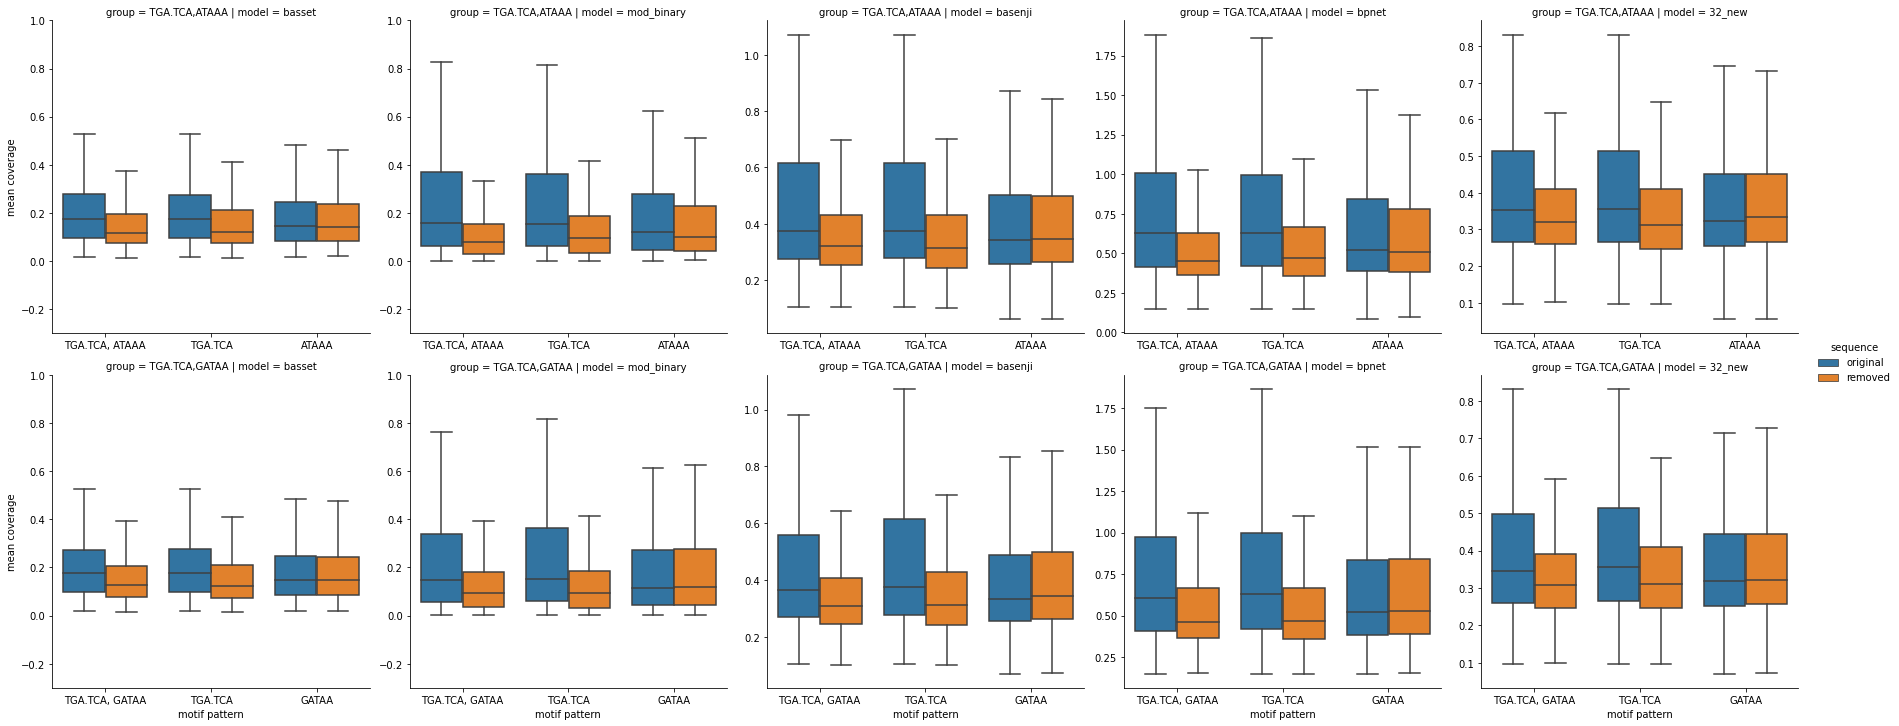

In [28]:
g = sns.catplot(data=all_dfs, x='motif pattern',y='mean coverage', row='group', sharex=False, hue='sequence',
            kind='box', sharey=False, col='model',showfliers = False, palette='tab10')
axs = g.axes
for r in range(axs.shape[0]):
    for c in range(2):
        axs[r][c].set_ylim(-0.3,1)

## multiple TGA.TCA occlusion

In [25]:
model_dict = {'run-20211019_161849-9ygdmjss':'mod_binary',
             'run-20210825_040148-nieq47kf': 'basset',
             'run-20211023_095131-w6okxt01': '32_new',
             'run-20210923_162932-56p3xy2p':'basenji',
              'run-20211013_133014-ku9mdrht': 'bpnet'
             }

/tmp/ipykernel_1492890/82030996.py:37: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1492890/82030996.py:37: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1492890/82030996.py:37: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipykernel_1492890/82030996.py:37: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])
/tmp/ipy

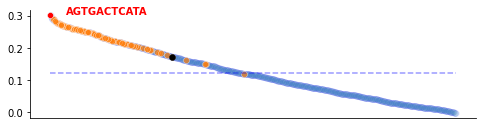

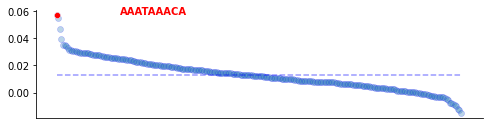

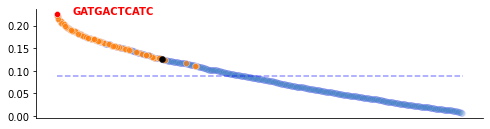

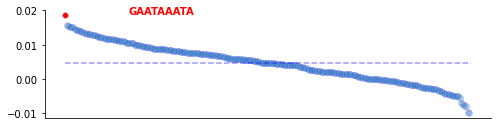

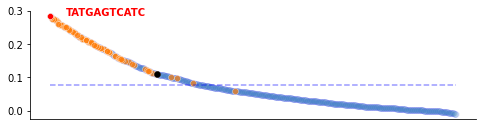

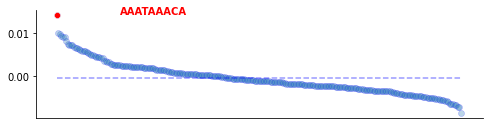

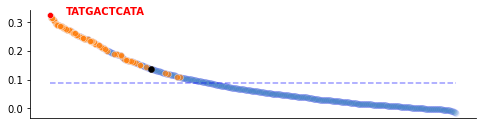

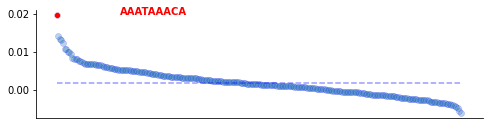

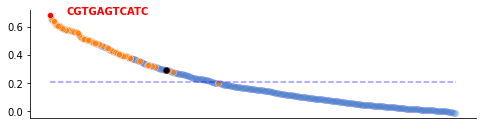

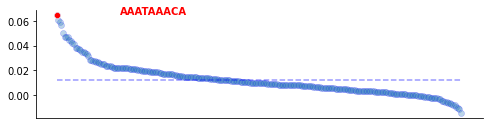

In [26]:
# flanks
cell_line = 'PC-3'

for run_name in model_dict.keys():
# run_name = 'run-20211023_095131-w6okxt01'

    for i, motif_insert in enumerate([[('TGA', 1024), ('TCA', 1024+len('TGA')+1)], [('ATAAA', 1024)]]):
        if i ==0:
            alpha=0.07
        else:
            alpha=0.3
        motif_pattern = '.'.join([m[0] for m in motif_insert])
        plt.figure(figsize=[8,2])
        flanks = pd.read_csv('/home/shush/old_grounhog/paper_figures/add_GIA_interaction/{}/{}_..{}../dinuc_N1000/flanks.csv'.format(run_name, motif_pattern))
        sorted_flanks = flanks[flanks['cell line']==cell_line].sort_values('mean difference')[::-1]
        sns.scatterplot(data=sorted_flanks, 
                        x='motif', y='mean difference', edgecolor='blue', alpha=alpha)
        mean_of_all = sorted_flanks['mean difference'].mean()
        plt.hlines(mean_of_all,0, len(sorted_flanks['motif'].values), 'blue', linestyles='--', alpha=0.4)

        plt.text(40, sorted_flanks.iloc[0,1], sorted_flanks.iloc[0,0], 
             horizontalalignment='left', size='medium', color='red', weight='semibold')

        if i == 0:
            pc3 = flanks[flanks['cell line']=='PC-3'].reset_index()
            jaspar_motifs = []
            for r, row in pc3.iterrows():
                m = row['motif']
                if m[0] in 'GAT' and m[1] in 'GAC' and m[5] in 'CG' and m[9] in 'TC' and m[10] in 'CGT':
                    jaspar_motifs.append(r)
            sns.scatterplot(data=pc3.iloc[jaspar_motifs], x='motif', y='mean difference', alpha=0.7)
            point_at_min = pc3.iloc[jaspar_motifs].sort_values('mean difference').iloc[4]
            p = np.argwhere(sorted_flanks['motif'].values==point_at_min['motif'])[0][0]
            point_df = sorted_flanks.iloc[p].to_frame().T
            sns.scatterplot(data=point_df, x='motif',
                            y='mean difference', color='k', edgecolor=None)
        plt.xticks([])
        a = sns.scatterplot(x=[0],y=[sorted_flanks.iloc[0,1]], color='r')
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        plt.ylabel('')
        plt.xlabel('')
        plt.savefig('7a_{}.svg'.format(i))